
###[Notícia do G1 São Paulo](http://g1.globo.com/sao-paulo/noticia/2015/03/cantareira-vai-145-todos-reservatorios-sobem.html)

![noticia](https://dl.dropboxusercontent.com/u/2057145/g1errou.png)

![infografico](https://dl.dropboxusercontent.com/u/2057145/reservatorios1403.jpg)
<!--![g1](reservatorios1403.jpg)-->


Fiquei desconfiado desse infografico. Quer dizer que já pagamos nossa "dívida" com o volume morto?

Vamos ver...

A sabesp disponibiliza dados para consulta [neste endereço](http://www2.sabesp.com.br/mananciais/DivulgacaoSiteSabesp.aspx), mas não faço idéia de como pegar os dados automaticamente... 

Ainda bem que uma [boa alma](https://github.com/rafaell-lycan) já fez uma [api](https://github.com/rafaell-lycan/sabesp-mananciais-api) que dá conta do serviço! Graças a ele pude escrever uma função bem meia boca pra capturar esses dados, o getData.

In [1]:
from sabesPy import getData
import pandas as pd
df = pd.DataFrame([getData('2014-03-14'), getData('2015-03-14')])

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns ## só pra deixar o matplotlib com o estilo bonitão do seaborn ;)
sns.set_context("talk")
sns.set_style("darkgrid", {"grid.linewidth": .5, "axes.facecolor": ".9"})
#pd.options.display.mpl_style = 'default' ## estilo ggplot

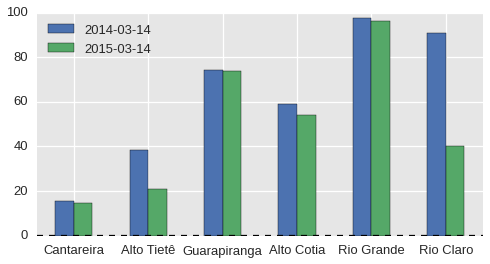

In [3]:
datasG1 = ['2014-03-14','2015-03-14']
df.ix[datasG1,:].T.plot(kind='bar', rot=0, figsize=(8,4))
plt.show()

OK. Tudo certo. Bate com os gráficos mostrados pelo G1, apenas está sendo mostrado de uma forma diferente. 

Maaas...

In [4]:
datas = ['2014-03-14',
         '2014-05-15', # pré-volume morto
         '2014-05-16', # estréia da "primeira reserva técnica", a.k.a. volume morto
         '2014-07-12', # data em que a "reserva normal" é esgotada
         '2014-10-23',
         '2014-10-24', # "segunda reserva técnica" ou "VOLUME MORTO 2: ELECTRIC BOOGALOO"
         '2015-01-01', # feliz ano novo ?
         '2015-03-14']
import numpy as np
df = pd.DataFrame(pd.concat(map(getData, datas), axis=1))
df = df.T

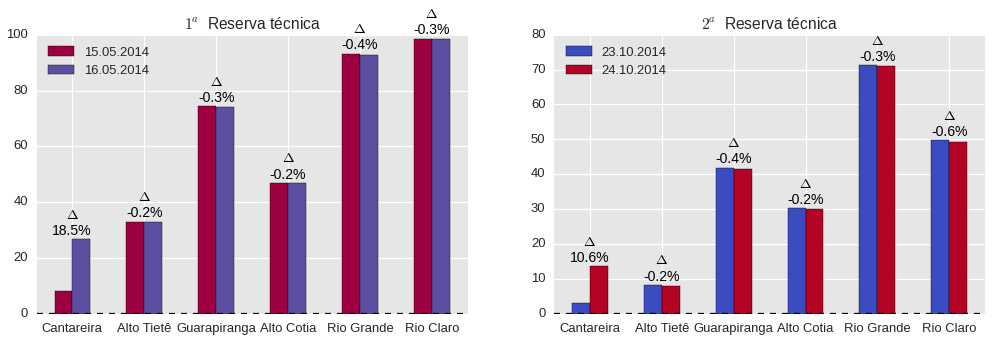

In [5]:
from sabesPy import plotSideBySide
dados = df.ix[['2014-05-15','2014-05-16']], df.ix[['2014-10-23','2014-10-24']]
            
plotSideBySide(dados, titles=['$1^a$ Reserva técnica', '$2^a$ Reserva técnica'])

o cantareira tem capacidade total de quase 1 trilhão de litros, segundo a matéria do G1. 

Então, entre os dias 15 e 16 de março, *POOF*: **180 bilhões** de litros surgiram num passe de mágica!

Depois, em outubro, *POOF*. Surgem mais **100 bilhões**. 


#QUE BRUXARIA É ESSA?!?

O próprio [site](http://www2.sabesp.com.br/mananciais/DivulgacaoSiteSabesp.aspx) da sabesp esclarece:


- A **primeira reserva técnica** entrou em operação em **16/05/2014** e acrescentou mais **182,5 bilhões** de litros ao sistema - 18,5% de acréscimo;

- A **segunda reserva técnica** entrou em operação em **24/10/2014** e acrescentou mais **105,4 bilhões** de litros ao sistema - 10,7% de acréscimo 


Ou seja, o percentual divulgado pela sabesp não é corrigido para descontar o volume morto e, portanto, comparar 14 de março desse ano com o ano passado não faz sentido.

O G1 errou. Mas o quanto errou? Será que já, pelo menos, pagamos nossa "dívida" com o volume morto?

## corrigindo o percentual do cantareira


Simples assim:
$$ Vol_1 = p \times Vol_0 $$

$$ Vol_{corrigido} = Vol_1 - Vol_{morto}$$

$$ p_{corrigido} = \frac{Vol_{corrigido}}{Vol_0}  $$

<table>
    <tr> 
        <td>     $Vol_1$     </td>  
        <td> o volume atual do sistema  </td>
    </tr>  <tr> 
        <td>     $Vol_0$     </td> 
        <td>  a capacidade máxima do reservatório (sem contar o volume morto) </td>
    </tr>  <tr> 
        <td>     $Vol_{corrigido}$     </td> 
        <td>  volume atual $-$ volume morto) </td>
    </tr>  <tr>
        <td>   $Vol_{morto}$ </td> 
        <td> advinha! </td> 
    </tr>  <tr> 
        <td>  $p$   </td> 
        <td>  o percentual divulgado pela sabesp </td>
    </tr>  <tr> 
        <td>$p_{corrigido}$  </td> 
        <td> o percentual corrigido</td>
</table>


essa correção foi implementada no "módulo" [sabesPy](http://github.com/varnion/sabesPy/blob/master/sabesPy.py)

In [6]:
from sabesPy import fixPerc
dFixed = df.copy()
dFixed.Cantareira = ([fixPerc(p, dia) for p, dia in zip(df.Cantareira, df.index)])

2014-03-14:  15.5 ===>  15.5
2014-05-15:   8.2 ===>   8.2
2014-05-16:  26.7 ===>   8.1  VOLUME MORTO 182.5 GL
2014-07-12:  18.5 ===>  -0.1  VOLUME MORTO 182.5 GL
2014-10-23:   3.0 ===> -15.6  VOLUME MORTO 182.5 GL
2014-10-24:  13.6 ===> -15.7  VOLUME MORTO 287.9 GL
2015-01-01:   7.2 ===> -22.1  VOLUME MORTO 287.9 GL
2015-03-14:  14.5 ===> -14.8  VOLUME MORTO 287.9 GL


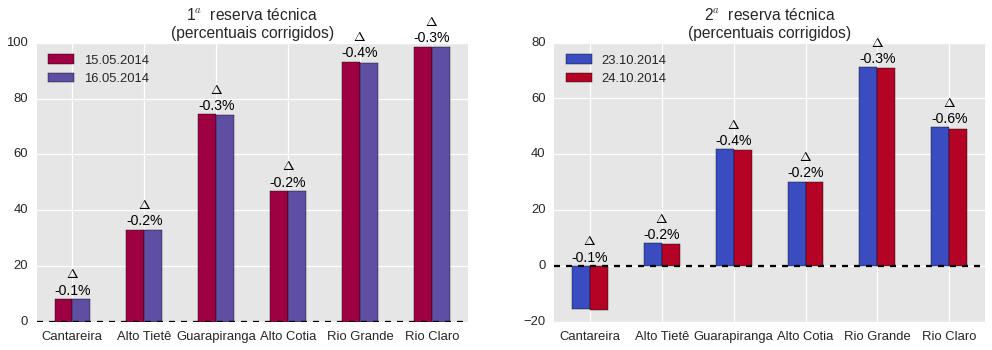

In [7]:
dados = dFixed.ix[['2014-05-15','2014-05-16']], dFixed.ix[['2014-10-23','2014-10-24']]
plotSideBySide(dados, 
    titles=['1$^a$ reserva técnica\n(percentuais corrigidos)', 
            '2$^a$ reserva técnica\n(percentuais corrigidos)'])

Pronto. Agora faz sentido, sem aquela variação absurda. 


Finalmente, comparemos o grafico com os dados usados pelo G1 e com dados corrigidos

Pronto. 
##O G1 errou

$-14.8 \neq 14.5$

~~vai ver só confundiram o sinal~~

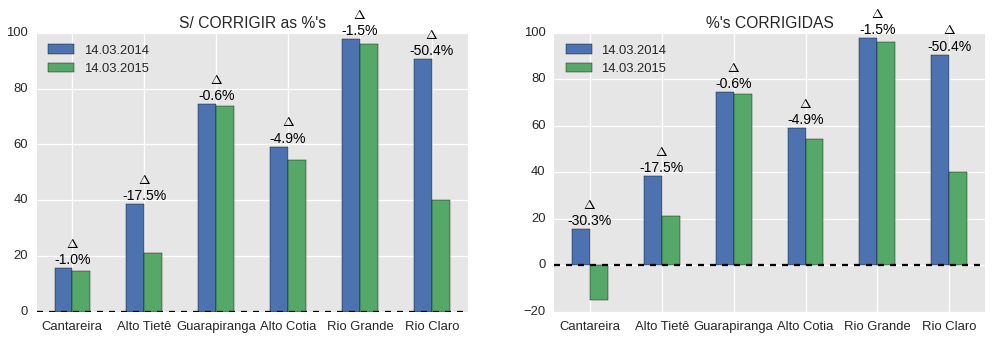

In [8]:
dados = df.ix[datasG1], dFixed.ix[datasG1]
plotSideBySide(dados,cm=[None,None],
    titles=["S/ CORRIGIR as %'s", "%'s CORRIGIDAS"])

O G1 errou catastróficamente. ~~errou feio, errou rude.~~


Estamos muito longe do nível do ano passado. 

(E mesmo que o cantareira estivesse com 15%, ainda seria uma situação crítica)

PS: Ainda falta corrigir o percentual pro Alto Tietê, que também incorporou um "volume morto".

#Sabesp divulga dados incorretos

vc deve ter notado a conta para pegar o volume atual está estranha. 

calculei assim:

$ Vol_1 = p \times Vol_0$ 

mas deveria ter calculado assim:

$ Vol_1 = p \times (Vol_0 + Vol_{morto})$


Eu mesmo comecei tentando calcular dessa forma, mas esse método não corrigia as variações que ocorreram qndo o volume morto foi incorporado.

Vamos corrigir os dados com essa outra formula e comparar os graficos.

In [9]:
def percFixer2(p,volMax, volumeMorto=0):
    volAtual = (volMax + volumeMorto)*(p/100) - volumeMorto
    q = 100*volAtual/volMax
    #import numpy as np
    q = round(q,1)
    return q

In [10]:
dFixed2 = df.copy()
dFixed2.Cantareira = [fixPerc(p, dia, fixFunc=percFixer2) for p, dia in zip(df.Cantareira, df.index)]

2014-03-14:  15.5 ===>  15.5
2014-05-15:   8.2 ===>   8.2
2014-05-16:  26.7 ===>  13.1  VOLUME MORTO 182.5 GL
2014-07-12:  18.5 ===>   3.4  VOLUME MORTO 182.5 GL
2014-10-23:   3.0 ===> -15.0  VOLUME MORTO 182.5 GL
2014-10-24:  13.6 ===> -11.7  VOLUME MORTO 287.9 GL
2015-01-01:   7.2 ===> -20.0  VOLUME MORTO 287.9 GL
2015-03-14:  14.5 ===> -10.6  VOLUME MORTO 287.9 GL


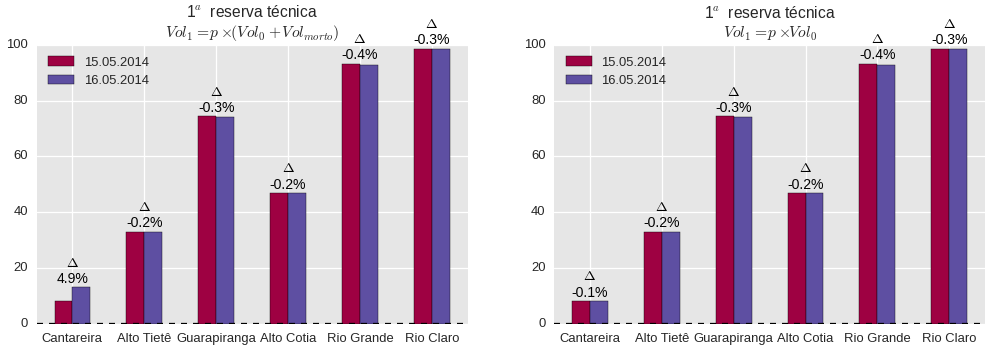

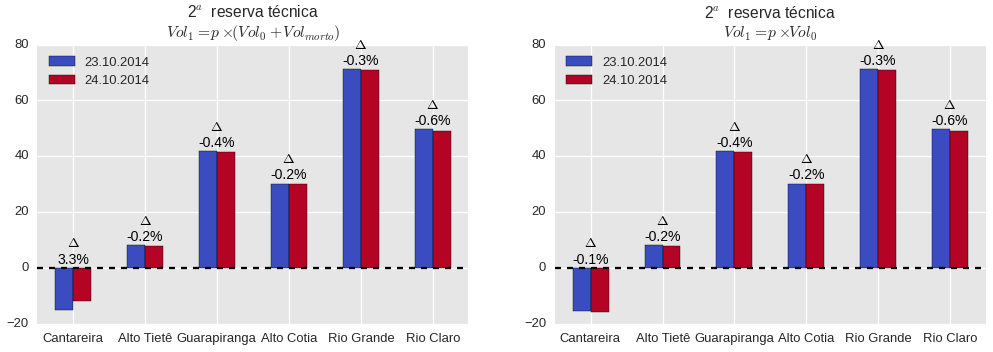

In [11]:
dados = [[dFixed2.ix[['2014-05-15','2014-05-16']], dFixed.ix[['2014-05-15','2014-05-16']]],
        [dFixed2.ix[['2014-10-23','2014-10-24']], dFixed.ix[['2014-10-23','2014-10-24']]]]

plotSideBySide(dados[0], cm=['Spectral', 'Spectral'],
    titles=['1$^a$ reserva técnica\n$ Vol_1 = p \\times (Vol_0 + Vol_{morto})$', 
            '1$^a$ reserva técnica\n$ Vol_1 = p \\times  Vol_0$'])

plotSideBySide(dados[1], cm=['coolwarm', 'coolwarm'],
    titles=['2$^a$ reserva técnica\n$ Vol_1 = p \\times (Vol_0 + Vol_{morto})$', 
            '2$^a$ reserva técnica\n$ Vol_1 = p \\times  Vol_0$'])

Viu?
A porcentagem divulgada pela Sabesp é falsa, pois faz de conta que a capacidade máxima do cantareira são os mesmos **980 bi L** anteriores à aquisição das reservas técnicas. (A capacidade atual do sistema é **1.3 tri L**!!!)

In [12]:
dadosCantareira = pd.DataFrame(pd.concat([df.Cantareira, dFixed2.Cantareira, dFixed.Cantareira], axis=1))

In [13]:
titles = ['$\%$ divulgada pela Sabesp ($p$)',
    '$ Vol_{atual} = p \\times (Vol_{max} +Vol_{morto})$',
    '$ Vol_{atual} = p \\times Vol_{max}$']
dadosCantareira.columns = titles
#dadosCantareira.index = pd.to_datetime(dadosCantareira.index)
from sabesPy import reverseDate
dadosCantareira.index = map(reverseDate, dadosCantareira.index)

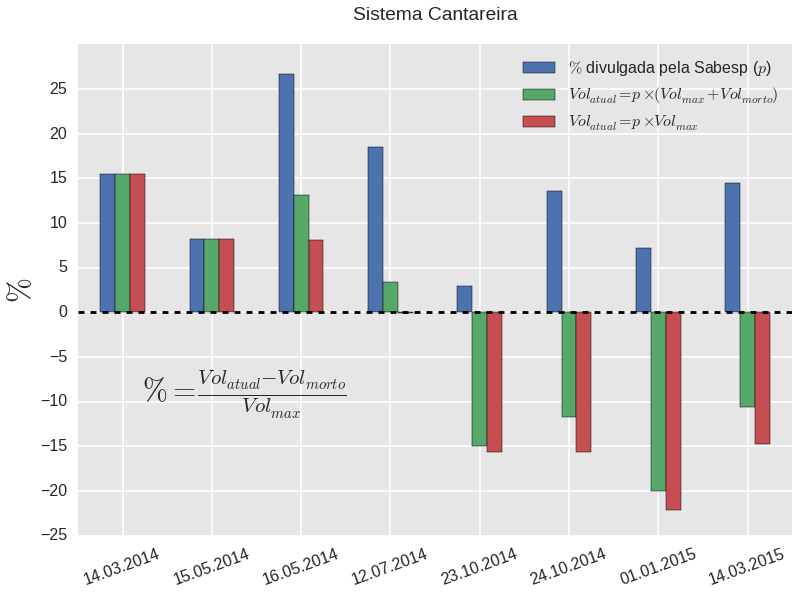

In [16]:
sns.set_context("poster")
ax = dadosCantareira.plot(kind='bar', ylim=(-25,30), yticks=range(-25,30,5), rot=20, title='Sistema Cantareira\n')
ax.set_ylabel("$\%$", fontsize=30)
ax.text(2.5, -10, r" $ \% =\frac{Vol_{atual} - Vol_{morto}}{Vol_{max}}  $", fontsize=30, ha='right')
plt.show()